In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

def get_calibration(calibration_images):

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    img_size = None

    # Step through the list and search for chessboard corners
    for fname in calibration_images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_size = gray.shape[::-1]

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    return cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

cv2.destroyAllWindows()

In [2]:
import cv2
class CalibratedCamera():

    def __init__(self, ret, mtx, dist, rvecs, tvecs):
        self.ret = ret
        self.mtx = mtx
        self.dist = dist
        self.rvecs = rvecs
        self.tvecs = tvecs

    def undistort_img(self, img):
        return cv2.undistort(img, self.mtx, self.dist, None, self.mtx)

    def warp_inverse(self, img):
        pass

In [3]:
image_fnames = glob.glob('./camera_cal/calibration*.jpg')
ret, mtx, dist, rvecs, tvecs = get_calibration(image_fnames)


In [4]:
camera = CalibratedCamera(ret, mtx, dist, rvecs, tvecs)

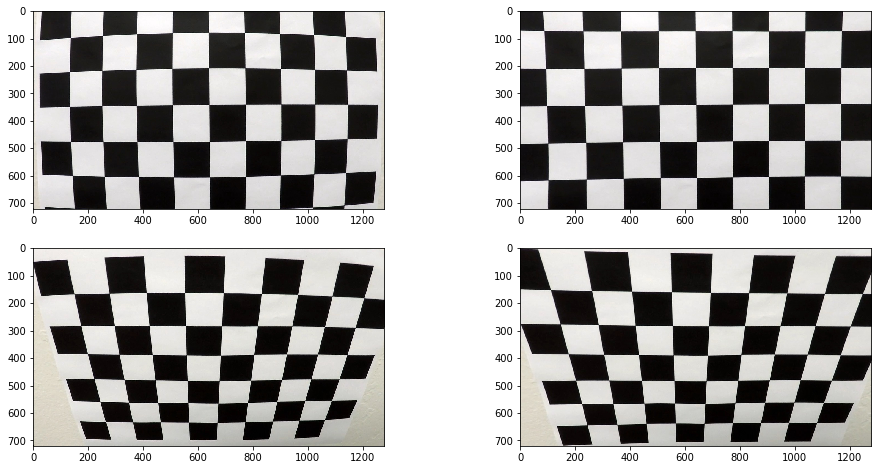

In [5]:
test_img1 = cv2.imread('./camera_cal/calibration1.jpg')
test_img1 = cv2.cvtColor(test_img1, cv2.COLOR_BGR2RGB)
test_img2 = cv2.imread('./camera_cal/calibration2.jpg')
test_img2 = cv2.cvtColor(test_img2, cv2.COLOR_BGR2RGB)
undistored_test_img1 = camera.undistort_img(test_img1)
undistored_test_img2 = camera.undistort_img(test_img2)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
ax = ax.ravel()

ax[0].imshow(test_img1)
ax[1].imshow(undistored_test_img1)
ax[2].imshow(test_img2)
ax[3].imshow(undistored_test_img2)

In [6]:
import cv2
def abs_sobel_thresh(img_gray, orient='x', thresh_min=0, thresh_max=255):
    if orient == 'x':
        sobel = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1)

    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return sbinary
    

In [7]:
def mag_thresh(img_gray, sobel_kernel=3, thresh_min=0, thresh_max=255):
    sobelx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh_min) & (gradmag <= thresh_max)] = 1
    return binary_output

In [8]:
def dir_threshold(img_gray, sobel_kernel=3, thresh_min_radian=0, thresh_max_radian=np.pi/2):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh_min_radian) & (absgraddir <= thresh_max_radian)] = 1
    return binary_output

In [9]:
def rgb_thresholds(img_path):
    img = cv2.imread(img_path)
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    R = rgb_img[:,:,0]
    G = rgb_img[:,:,1]
    B = rgb_img[:,:,2]
    
    fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(16, 8))
    ax = ax.ravel()
    
    r_binary = np.zeros_like(R)
    g_binary = np.zeros_like(G)
    b_binary = np.zeros_like(B)
    
    r_binary[(R > 200) & (R <= 255)] = 1
    g_binary[(G > 200) & (G <= 255)] = 1
    b_binary[(B > 200) & (B <= 255)] = 1
    
    ax[0].imshow(R, cmap='gray')
    ax[1].imshow(r_binary, cmap='gray')
    ax[2].imshow(G, cmap='gray')
    ax[3].imshow(g_binary, cmap='gray')
    ax[4].imshow(B, cmap='gray')
    ax[5].imshow(b_binary, cmap='gray')

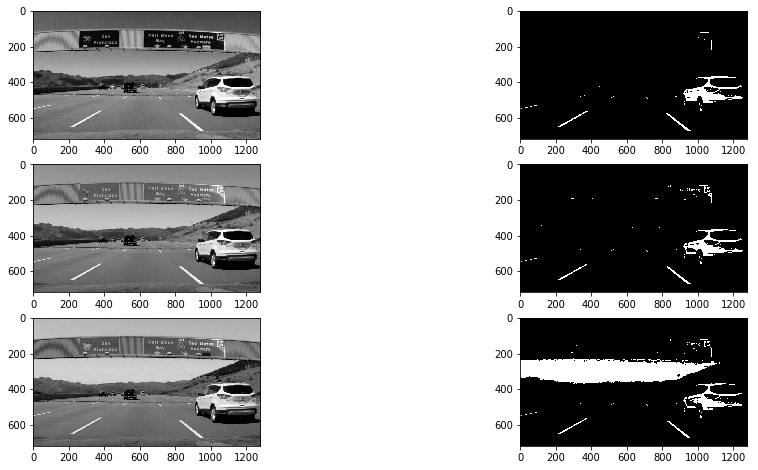

In [10]:
rgb_thresholds('./test_images/signs_vehicles_xygrad.jpg')

In [11]:
def hls_thresholds(img_path):
    img = cv2.imread(img_path)
    hls_img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    H = hls_img[:,:,0]
    L = hls_img[:,:,1]
    S = hls_img[:,:,2]
    
    fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(16, 8))
    ax = ax.ravel()
    
    h_binary = np.zeros_like(H)
    l_binary = np.zeros_like(L)
    s_binary = np.zeros_like(S)
    
    h_binary[(H > 140) & (H <= 180)] = 1
    l_binary[(L > 90) & (L <= 255)] = 1
    s_binary[(S > 90) & (S <= 255)] = 1
    
    ax[0].imshow(H, cmap='gray')
    ax[1].imshow(h_binary, cmap='gray')
    ax[2].imshow(L, cmap='gray')
    ax[3].imshow(l_binary, cmap='gray')
    ax[4].imshow(S, cmap='gray')
    ax[5].imshow(s_binary, cmap='gray')

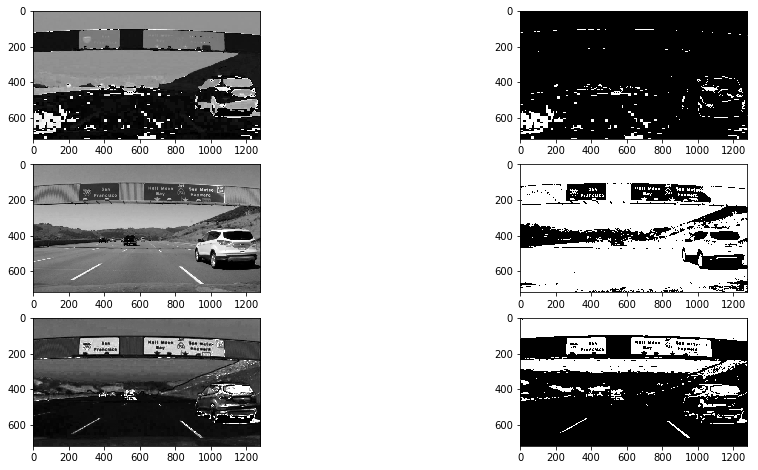

In [12]:
hls_thresholds('./test_images/signs_vehicles_xygrad.jpg')

In [90]:
def apply_perspective(img):
    top_left_src = [570, 468]
    top_right_src = [714, 468]
    bottom_right_src = [1106, 720]
    bottom_left_src = [207, 720]
    
    top_left_dst = [320, 1]
    top_right_dst = [920, 1]
    bottom_right_dst = [920, 720]
    bottom_left_dst = [320, 720]
    
    src = np.array([top_left_src, top_right_src, bottom_right_src, bottom_left_src], np.float32)
    dst = np.float32([top_left_dst ,top_right_dst, bottom_right_dst, bottom_left_dst])
                       
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return cv2.warpPerspective(img, M, (img.shape[1], img.shape[0])), Minv

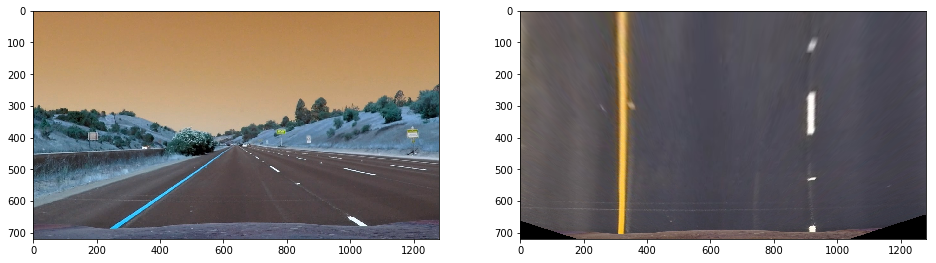

In [14]:
img = cv2.imread('./test_images/straight_lines1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
transformed = apply_perspective(img)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
ax = ax.ravel()

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
ax[0].imshow(img)
ax[1].imshow(transformed)

In [15]:
import math
def test_run(img_path, sobel_kernel=11, thresh_min=40, thresh_max=150):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    undistored = camera.undistort_img(gray)
    
    gradx = abs_sobel_thresh(gray, orient='x', thresh_min=50, thresh_max=150)
    grady = abs_sobel_thresh(gray, orient='y', thresh_min=50, thresh_max=150)
    mag_binary = mag_thresh(gray, sobel_kernel=sobel_kernel, thresh_min=10, thresh_max=150)
    min_radian = 0.7
    max_radian = 1.3
    dir_binary = dir_threshold(gray, sobel_kernel=sobel_kernel, thresh_min_radian=min_radian, thresh_max_radian=max_radian)
    
    combined = np.zeros_like(dir_binary)
    combined[((grady == 1) & (dir_binary == 1) & (mag_binary == 1))] = 1
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    ax = ax.ravel()

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax[0].imshow(img)
    ax[1].imshow(combined, cmap='gray')


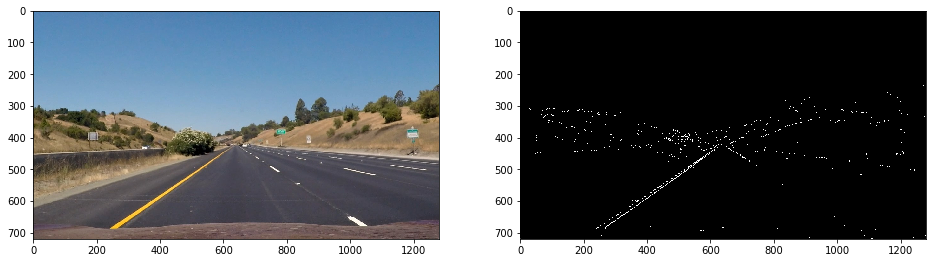

In [16]:
test_run('./test_images/straight_lines1.jpg')

In [17]:
def apply_thresholds(img_rgb, sobel_kernel=9):
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

    gradx = abs_sobel_thresh(gray, orient='x', thresh_min=50, thresh_max=150)
    grady = abs_sobel_thresh(gray, orient='y', thresh_min=50, thresh_max=150)
    mag_binary = mag_thresh(gray, sobel_kernel=sobel_kernel, thresh_min=30, thresh_max=150)
    min_radian = 0.7
    max_radian = 1.3
    dir_binary = dir_threshold(gray, sobel_kernel=sobel_kernel, thresh_min_radian=min_radian, thresh_max_radian=max_radian)
    
    combined = np.zeros_like(dir_binary)
    combined[((grady == 1) & (dir_binary == 1) & (mag_binary == 1))] = 1
    
    hls_img = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HLS)
    S = hls_img[:,:,2]
    
    s_binary = np.zeros_like(S)
    s_binary[(S > 90) & (S <= 255)] = 1
    
    result = np.zeros_like(combined)
    result[(s_binary == 1) & (grady == 1)] = 1
    return s_binary
    

In [88]:
def pipeline(img):
    undistored = camera.undistort_img(img)
    transformed, Minv = apply_perspective(undistored)
    binaried = apply_thresholds(transformed)
    return binaried, Minv

img = cv2.imread('./test_images/test3.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pipelined = pipeline(img)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
ax = ax.ravel()

ax[0].imshow(img)
ax[1].imshow(pipelined, cmap='gray')

AttributeError: module 'cv2' has no attribute 'getperspectivetransform'

In [28]:
import numpy as np
import cv2


def apply_sliding_window(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, out_img, left_lane_inds, right_lane_inds


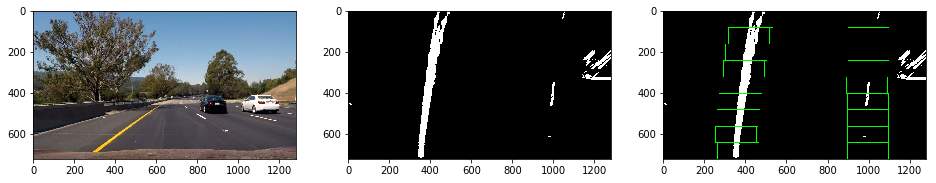

In [106]:
img = cv2.imread('./test_images/test6.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

pipelined, Minv = pipeline(img)
left_fit, right_fit, out_img, left_lane_inds, right_lane_inds = apply_sliding_window(pipelined)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))
ax = ax.ravel()

ax[0].imshow(img)
ax[1].imshow(pipelined, cmap='gray')
ax[2].imshow(out_img)

In [107]:
def measure_curvature(binary_warped, left_lane_inds, right_lane_inds):
    height = binary_warped.shape[0]
    ploty = np.linspace(0, height - 1, num=height)

    # Find X and Y positions of non-zeros
    nonzero = binary_warped.nonzero()
    nonzero_x = np.array(nonzero[1])
    nonzero_y = np.array(nonzero[0])
    
    leftx = nonzero_x[left_lane_inds]
    lefty = nonzero_y[left_lane_inds]
    rightx = nonzero_x[right_lane_inds]
    righty = nonzero_y[right_lane_inds]
    
    if len(leftx) and len(rightx):
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        y_eval = np.max(ploty)
        
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
        return left_curverad, right_curverad

In [108]:
img = cv2.imread('./test_images/test6.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

pipelined, Minv = pipeline(img)
left_fit, right_fit, out_img, left_lane_inds, right_lane_inds = apply_sliding_window(pipelined)
left_curve, right_curve = measure_curvature(pipelined, left_lane_inds, right_lane_inds)

In [109]:
print(left_curve, right_curve)

1693.18259126 1848.01403148


In [114]:
def draw(warped, original, left_fit, right_fit, Minv):
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    h = warped.shape[0]
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (original.shape[1], original.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(original, 1, newwarp, 0.3, 0)
    return result

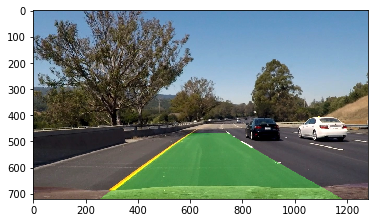

In [116]:
result = draw(pipelined, img, left_fit, right_fit, Minv)
plt.imshow(result)